In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [21]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- Load and Clean Data ---
weather = pd.read_csv("ten_year_data.csv", index_col="DATE")

# Convert index to datetime
weather.index = pd.to_datetime(weather.index)

# Filter data to 2015-01-01 to 2025-01-31
weather = weather.loc["2015-01-01":"2025-01-31"]

# Calculate null percentages and keep columns with <5% missing values
null_percent = weather.apply(pd.isnull).sum() / weather.shape[0]
valid_columns = weather.columns[null_percent < 0.05]
weather = weather[valid_columns].copy()

# Drop non-numeric columns (e.g., 'station', 'name') since they are not predictors
weather = weather.drop(['station', 'name'], axis=1, errors='ignore')

# Forward fill missing values
weather = weather.ffill()

In [22]:
weather.shape


(3684, 13)

In [23]:
weather

,STATION,NAME,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
DATE,,,,,,,,,,,,,
2015-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",17.22,0.00,0.0,0.0,33,40,28,230.0,230.0,25.9,32.0
2015-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",13.65,0.00,0.0,0.0,39,45,35,300.0,300.0,23.9,30.0
2015-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",9.17,0.94,0.0,0.0,36,47,30,90.0,100.0,18.1,23.0
2015-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",10.07,0.47,0.0,0.0,47,55,43,290.0,290.0,28.0,36.0
2015-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",19.69,0.00,0.0,0.0,43,51,23,280.0,290.0,33.1,48.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",13.42,0.00,0.0,0.0,35,42,29,230.0,230.0,23.9,33.1
2025-01-28,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",16.11,0.00,0.0,0.0,40,46,30,300.0,300.0,31.1,46.1
2025-01-29,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",19.91,0.00,0.0,0.0,42,55,34,300.0,290.0,36.9,53.0


In [24]:
# Convert column names to lowercase
weather.columns = weather.columns.str.lower()

# Calculate mean temperature
weather["mean_temp"] = (weather["tmax"] + weather["tmin"]) / 2

# Create target: next day's mean temperature
weather["target"] = weather["mean_temp"].shift(-1)

# Forward fill the last row's target
weather = weather.ffill()

# Verify no missing values
print("Missing values:\n", weather.apply(pd.isnull).sum())

# --- Modeling ---
# Define predictors
predictors = ["prcp", "snow", "snwd", "tmax", "tmin", "mean_temp"]

# Prepare data for Ridge and Random Forest
X = weather[predictors]
y = weather["target"]

# Chronological train-test split
train_size = int(len(X) * 0.8)
X_train_rf_ridge, X_test_rf_ridge = X.iloc[:train_size], X.iloc[train_size:]
y_train_rf_ridge, y_test_rf_ridge = y.iloc[:train_size], y.iloc[train_size:]

Missing values:
 station      0
name         0
awnd         0
prcp         0
snow         0
snwd         0
tavg         0
tmax         0
tmin         0
wdf2         0
wdf5         0
wsf2         0
wsf5         0
mean_temp    0
target       0
dtype: int64



--- Exploratory Data Analysis ---


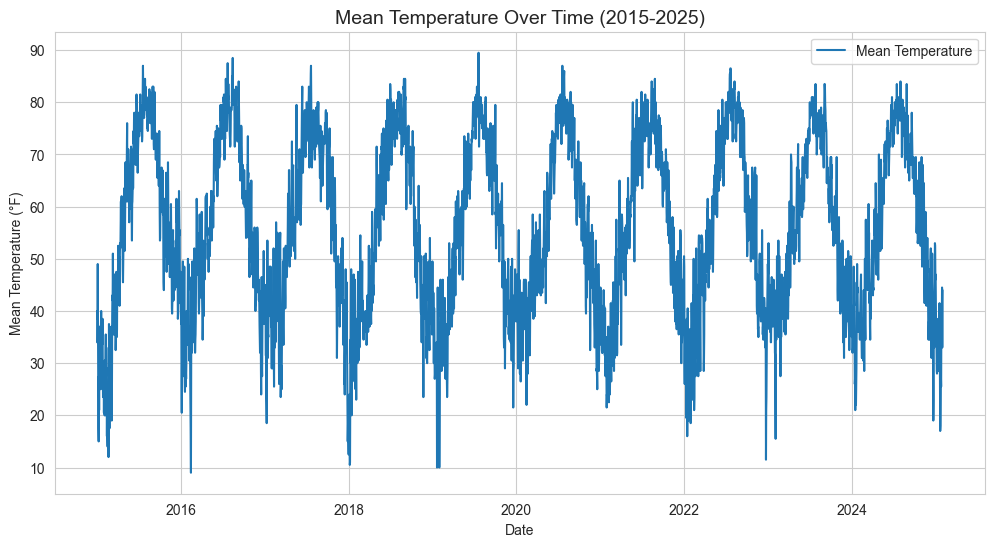

In [25]:
# --- Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis ---")
sns.set_style("whitegrid")

# 1. Time-series plot of mean temperature
plt.figure(figsize=(12, 6))
plt.plot(weather.index, weather["mean_temp"], label="Mean Temperature")
plt.title("Mean Temperature Over Time (2015-2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Mean Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

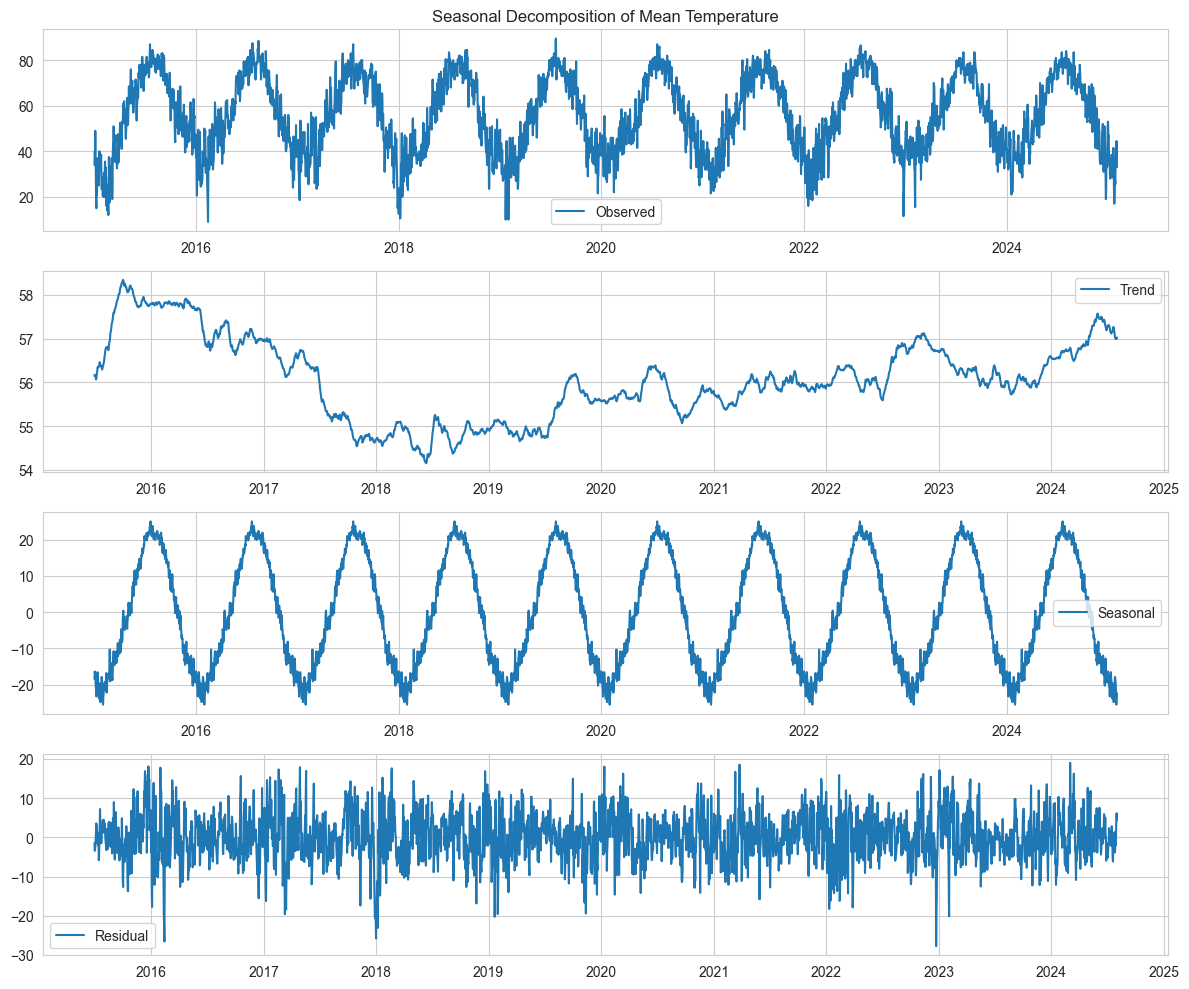

In [26]:
# 2. Seasonal decomposition
decomposition = seasonal_decompose(weather["mean_temp"], model="additive", period=365)
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label="Observed")
plt.title("Seasonal Decomposition of Mean Temperature")
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label="Trend")
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonal")
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label="Residual")
plt.legend()
plt.tight_layout()
plt.show()

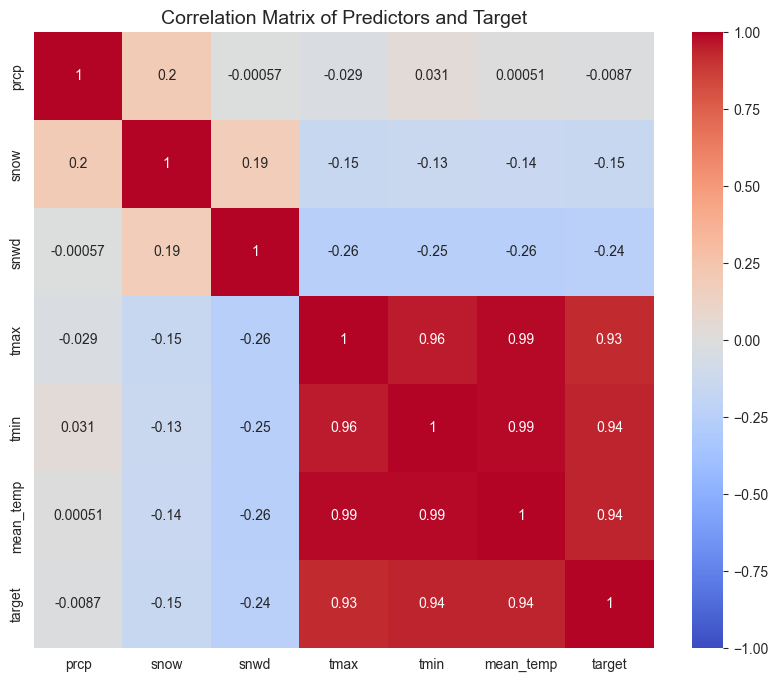

In [27]:
# 3. Correlation heatmap
plt.figure(figsize=(10, 8))
predictors = ["prcp", "snow", "snwd", "tmax", "tmin", "mean_temp"]
corr = weather[predictors + ["target"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of Predictors and Target", fontsize=14)
plt.show()

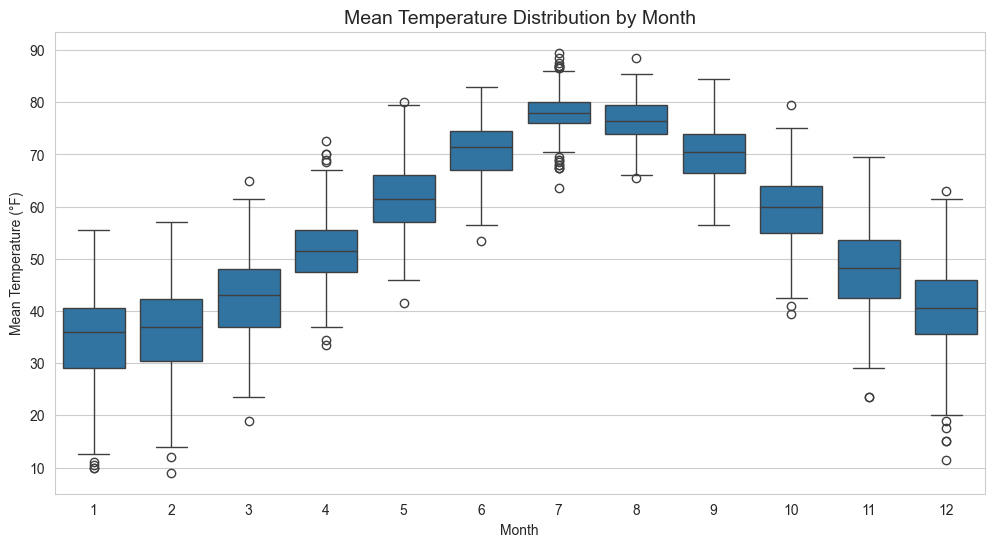

In [28]:
# 4. Box plot by month
weather["month"] = weather.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(x="month", y="mean_temp", data=weather)
plt.title("Mean Temperature Distribution by Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Mean Temperature (°F)")
plt.show()

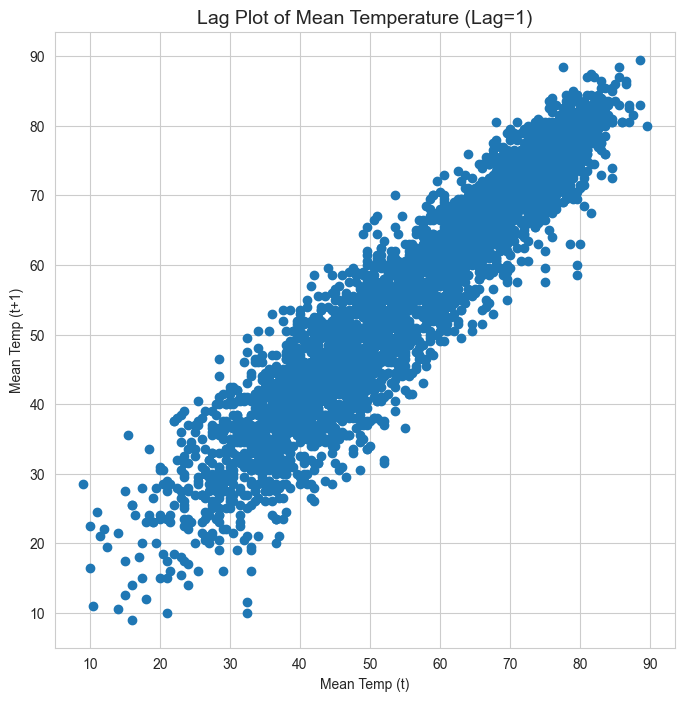

In [29]:
# 5. Lag plot
plt.figure(figsize=(8, 8))
lag_plot(weather["mean_temp"], lag=1)
plt.title("Lag Plot of Mean Temperature (Lag=1)", fontsize=14)
plt.xlabel("Mean Temp (t)")
plt.ylabel("Mean Temp (t+1)")
plt.grid(True)
plt.show()

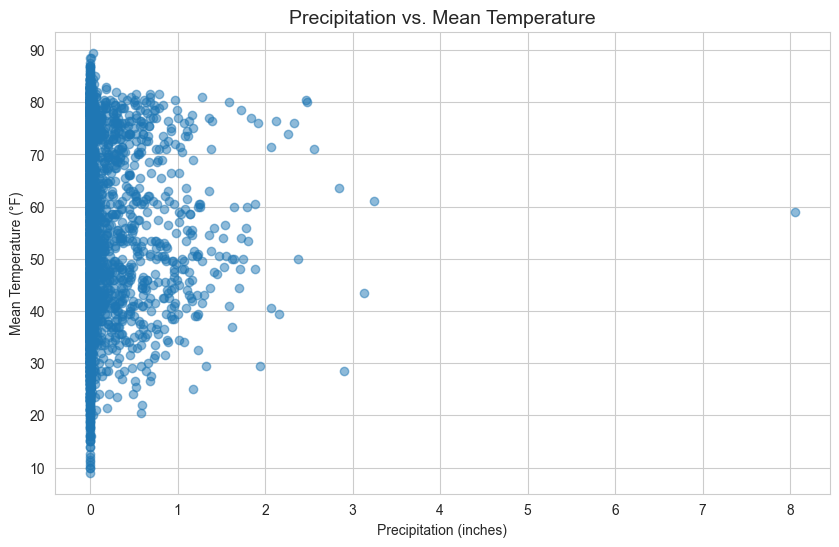

In [30]:
# 6. Precipitation vs. mean temperature scatter
plt.figure(figsize=(10, 6))
plt.scatter(weather["prcp"], weather["mean_temp"], alpha=0.5)
plt.title("Precipitation vs. Mean Temperature", fontsize=14)
plt.xlabel("Precipitation (inches)")
plt.ylabel("Mean Temperature (°F)")
plt.grid(True)
plt.show()

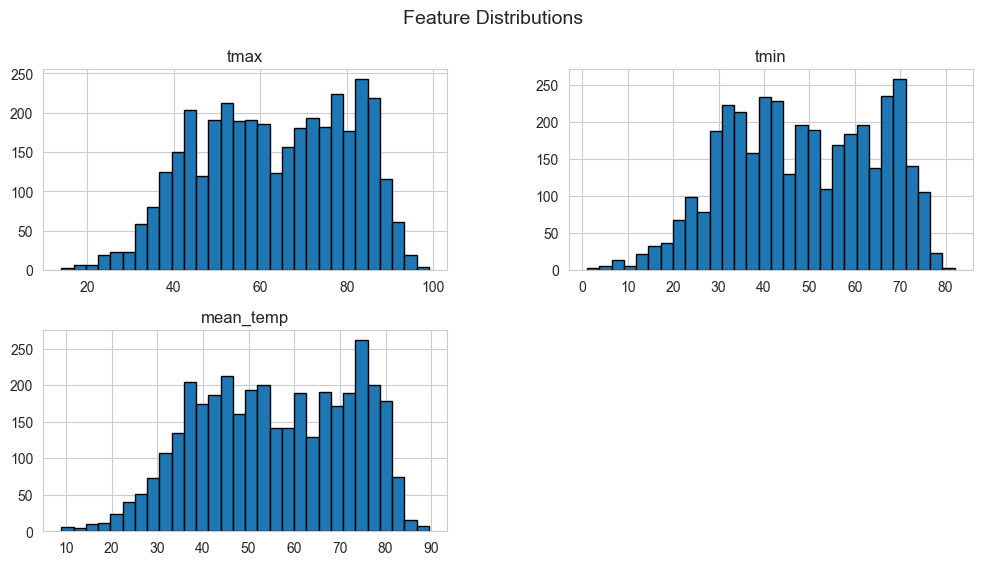

In [31]:
# 8. Histograms of numerical columns
weather[["tmax", "tmin", "mean_temp"]].hist(figsize=(12, 6), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

In [32]:
# --- Ridge Regression ---
print("\n--- Ridge Regression ---")
rr = Ridge(alpha=0.1)
rr.fit(X_train_rf_ridge, y_train_rf_ridge)
predictions_rr = rr.predict(X_test_rf_ridge)
predictions_rr = pd.Series(predictions_rr, index=X_test_rf_ridge.index)

# Compute errors for Ridge
mae_rr = mean_absolute_error(y_test_rf_ridge, predictions_rr)
mse_rr = mean_squared_error(y_test_rf_ridge, predictions_rr)
rmse_rr = mse_rr ** 0.5
r2_rr = r2_score(y_test_rf_ridge, predictions_rr)
mape_rr = mean_absolute_percentage_error(y_test_rf_ridge, predictions_rr)

print(f"Ridge MAE: {mae_rr:.2f} °F")
print(f"Ridge MSE: {mse_rr:.2f}")
print(f"Ridge RMSE: {rmse_rr:.2f} °F")
print(f"Ridge R²: {r2_rr*100:.2f}%")
print(f"Ridge MAPE: {mape_rr:.2f}%")


--- Ridge Regression ---
Ridge MAE: 3.93 °F
Ridge MSE: 25.05
Ridge RMSE: 5.01 °F
Ridge R²: 89.71%
Ridge MAPE: 8.14%


In [33]:
# --- Random Forest Regressor ---
print("\n--- Random Forest Regressor ---")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_rf_ridge, y_train_rf_ridge)
predictions_rf = rf.predict(X_test_rf_ridge)
predictions_rf = pd.Series(predictions_rf, index=X_test_rf_ridge.index)

# Compute errors for Random Forest
mae_rf = mean_absolute_error(y_test_rf_ridge, predictions_rf)
mse_rf = mean_squared_error(y_test_rf_ridge, predictions_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test_rf_ridge, predictions_rf)
mape_rf = mean_absolute_percentage_error(y_test_rf_ridge, predictions_rf)

print(f"Random Forest MAE: {mae_rf:.2f} °F")
print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f} °F")
print(f"Random Forest R²: {r2_rf*100:.2f}%")
print(f"Random Forest MAPE: {mape_rf:.2f}%")


--- Random Forest Regressor ---
Random Forest MAE: 4.42 °F
Random Forest MSE: 33.47
Random Forest RMSE: 5.79 °F
Random Forest R²: 86.26%
Random Forest MAPE: 9.08%


In [34]:
# --- Decision Tree Regressor ---
print("\n--- Decision Tree Regressor ---")
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train_rf_ridge, y_train_rf_ridge)
predictions_dt = dt.predict(X_test_rf_ridge)
predictions_dt = pd.Series(predictions_dt, index=X_test_rf_ridge.index)

# Compute errors for Decision Tree
mae_dt = mean_absolute_error(y_test_rf_ridge, predictions_dt)
mse_dt = mean_squared_error(y_test_rf_ridge, predictions_dt)
rmse_dt = mse_dt ** 0.5
r2_dt = r2_score(y_test_rf_ridge, predictions_dt)
mape_dt = mean_absolute_percentage_error(y_test_rf_ridge, predictions_dt)
print(f"Decision Tree MAE: {mae_dt:.2f} °F")
print(f"Decision Tree MSE: {mse_dt:.2f}")
print(f"Decision Tree RMSE: {rmse_dt:.2f} °F")
print(f"Decision Tree R²: {r2_dt*100:.2f}%")
print(f"Decision Tree MAPE: {mape_dt:.2f}%")


--- Decision Tree Regressor ---
Decision Tree MAE: 4.58 °F
Decision Tree MSE: 37.04
Decision Tree RMSE: 6.09 °F
Decision Tree R²: 84.79%
Decision Tree MAPE: 9.51%


In [35]:
# --- XGBoost Regressor ---
print("\n--- XGBoost Regressor ---")
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_rf_ridge, y_train_rf_ridge)
predictions_xgb = xgb_model.predict(X_test_rf_ridge)
predictions_xgb = pd.Series(predictions_xgb, index=X_test_rf_ridge.index)

# Compute errors for XGBoost
mae_xgb = mean_absolute_error(y_test_rf_ridge, predictions_xgb)
mse_xgb = mean_squared_error(y_test_rf_ridge, predictions_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test_rf_ridge, predictions_xgb)
mape_xgb = mean_absolute_percentage_error(y_test_rf_ridge, predictions_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f} °F")
print(f"XGBoost MSE: {mse_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f} °F")
print(f"XGBoost R²: {r2_xgb*100:.2f}%")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")


--- XGBoost Regressor ---
XGBoost MAE: 3.85 °F
XGBoost MSE: 24.93
XGBoost RMSE: 4.99 °F
XGBoost R²: 89.76%
XGBoost MAPE: 7.91%



--- LSTM Model ---
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 3405.4016 - val_loss: 1591.4182 - learning_rate: 5.0000e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 634.0859 - val_loss: 211.2004 - learning_rate: 5.0000e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 214.2288 - val_loss: 93.9073 - learning_rate: 5.0000e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 114.3623 - val_loss: 65.0119 - learning_rate: 5.0000e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 90.0184 - val_loss: 61.8155 - learning_rate: 5.0000e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 79.4927 - val_loss: 59.4874 - learning_rate: 5.0000e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 85.5237 - val_loss: 59.3090 - learning_rate: 5.0000e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 75.6918 - val_loss: 58.3119 - learning_rate: 5.0000e-04
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13

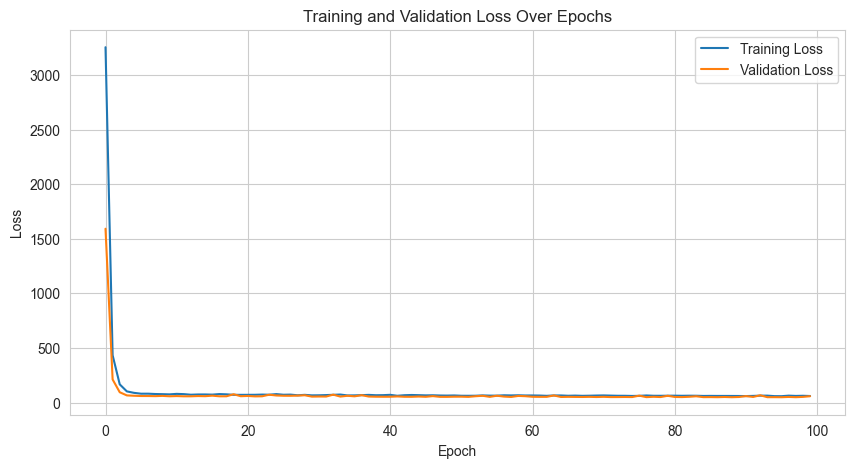

In [36]:
# --- LSTM Model ---
print("\n--- LSTM Model ---")
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weather[predictors])

# Create lagged dataset for LSTM
def create_lagged_dataset(data, target, timesteps=7):
  X, y = [], []
  for i in range(timesteps, len(data)):
      X.append(data[i-timesteps:i, :])
      y.append(target[i])
  return np.array(X), np.array(y)

timesteps = 7
X_lstm, y_lstm = create_lagged_dataset(scaled_data, weather["target"].values, timesteps)

# Split data chronologically
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Build LSTM model
model = Sequential([
  Input(shape=(timesteps, len(predictors))),
  LSTM(96, activation='relu'),
  Dropout(0.2),
  Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  Dense(1, activation='linear')
])

# Compile model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Train model
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_split=0.3,
                  callbacks=[EarlyStopping(patience=40), lr_schedule], verbose=1)

# Make predictions
y_pred_lstm = model.predict(X_test_lstm).flatten()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Evaluate LSTM
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
rmse_lstm = mse_lstm ** 0.5
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_lstm, y_pred_lstm)

print(f"LSTM MAE: {mae_lstm:.2f} °F")
print(f"LSTM MSE: {mse_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f} °F")
print(f"LSTM R²: {r2_lstm*100:.2f}%")
print(f"LSTM MAPE: {mape_lstm:.2f}%")

LSTM MAE: 5.56 °F
LSTM MSE: 50.97
LSTM RMSE: 7.14 °F
LSTM R²: 79.06%
LSTM MAPE: 12.30%


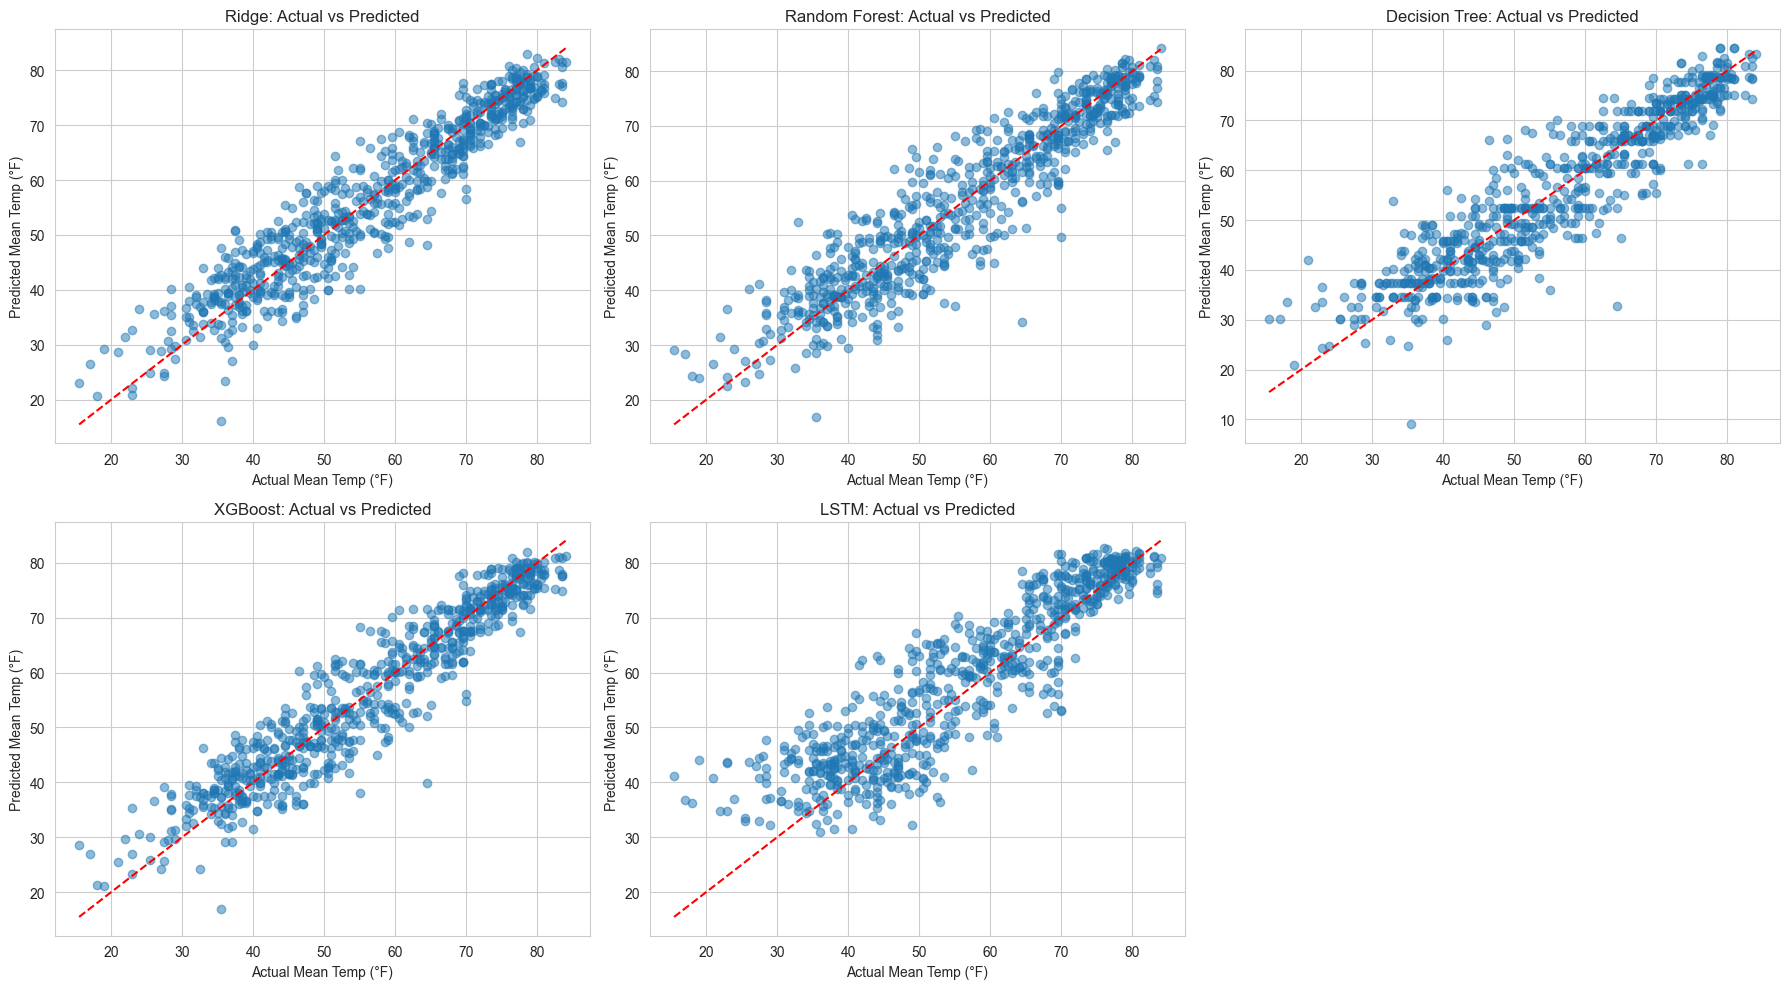

In [38]:
# --- Visualization of Results ---
plt.figure(figsize=(18, 10))

# Ridge
plt.subplot(2, 3, 1)
plt.scatter(y_test_rf_ridge, predictions_rr, alpha=0.5)
plt.plot([y_test_rf_ridge.min(), y_test_rf_ridge.max()],
      [y_test_rf_ridge.min(), y_test_rf_ridge.max()], 'r--')
plt.title("Ridge: Actual vs Predicted")
plt.xlabel("Actual Mean Temp (°F)")
plt.ylabel("Predicted Mean Temp (°F)")

# Random Forest
plt.subplot(2, 3, 2)
plt.scatter(y_test_rf_ridge, predictions_rf, alpha=0.5)
plt.plot([y_test_rf_ridge.min(), y_test_rf_ridge.max()],
      [y_test_rf_ridge.min(), y_test_rf_ridge.max()], 'r--')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Mean Temp (°F)")
plt.ylabel("Predicted Mean Temp (°F)")

# Decision Tree
plt.subplot(2, 3, 3)
plt.scatter(y_test_rf_ridge, predictions_dt, alpha=0.5)
plt.plot([y_test_rf_ridge.min(), y_test_rf_ridge.max()],
      [y_test_rf_ridge.min(), y_test_rf_ridge.max()], 'r--')
plt.title("Decision Tree: Actual vs Predicted")
plt.xlabel("Actual Mean Temp (°F)")
plt.ylabel("Predicted Mean Temp (°F)")

# XGBoost
plt.subplot(2, 3, 4)
plt.scatter(y_test_rf_ridge, predictions_xgb, alpha=0.5)
plt.plot([y_test_rf_ridge.min(), y_test_rf_ridge.max()],
      [y_test_rf_ridge.min(), y_test_rf_ridge.max()], 'r--')
plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Actual Mean Temp (°F)")
plt.ylabel("Predicted Mean Temp (°F)")

# LSTM
plt.subplot(2, 3, 5)
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.5)
plt.plot([y_test_lstm.min(), y_test_lstm.max()],
      [y_test_lstm.min(), y_test_lstm.max()], 'r--')
plt.title("LSTM: Actual vs Predicted")
plt.xlabel("Actual Mean Temp (°F)")
plt.ylabel("Predicted Mean Temp (°F)")

plt.tight_layout()
plt.show()